In [1]:
%load_ext autoreload
%autoreload 2

import community as community_louvain
from copy import deepcopy
from collections import OrderedDict
import cv2
import copy
import os
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp
import numpy as np
import point_cloud_utils as pcu
import torch
import torch.nn.functional as F
from skimage.transform import resize
from skimage.color import rgb2gray
import tqdm

import torch
import torchvision

import dense_correspondence_manipulation.utils.utils as utils

import meshcat
import meshcat.geometry as g

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.config import CfgNode as CN
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.data.datasets import load_coco_json
from detectron2.engine import DefaultTrainer, DefaultPredictor, default_argument_parser, default_setup, launch
from detectron2.evaluation import inference_on_dataset, COCOEvaluator
from detectron2.modeling import build_model
from detectron2.utils.events import EventStorage
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import scene_generation.inverse_graphics.synthetic_scene_database_loader as loader
from scene_generation.inverse_graphics.synthetic_scene_database_loader import XenRCNNMapper
import scene_generation.inverse_graphics.keypoint_mcmc.roi_heads as roi_heads
from scene_generation.inverse_graphics.keypoint_mcmc.particle_filter_icp import *

np.set_printoptions(precision=2)
torch.set_default_tensor_type(torch.FloatTensor)

DATA_ROOT = "/home/gizatt/data/generated_cardboard_envs/"
DETECTRON_ROOT = "/home/gizatt/tools/detectron2/"


class InstanceCloud():
    def __init__(self, pts, colors, descriptors):
        self.pts = pts
        self.descriptors = descriptors
        self.colors = colors
    def get_augmented_pts(self, descriptor_factor=1.):
        return np.vstack([self.pts, descriptor_factor*self.descriptors])
    
%matplotlib inline
def cv2_imshow(im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')

print(torchvision.__file__)

load_dict = torch.load("run_on_all_records.pt")
all_instance_clouds_by_record = load_dict["all_instance_clouds_by_record"]
affinities_by_record = load_dict["affinities_by_record"]
clusters_by_record = load_dict["clusters_by_record"]

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/torchvision-0.6.0a0+fb562f5-py3.6-linux-x86_64.egg/torchvision/__init__.py


In [2]:
import open3d as o3d
import copy
import matplotlib.cm as cm
import numpy as np

clusters = []
for c in list(clusters_by_record.values())[:10]:
    clusters += c
cluster = clusters[3]
    
vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")
vis.delete()


def compute_unit_box_descriptors(pts, normals):
    # Descriptor is the viridis color coding
    # of the distance to the center of each pt's face.
    face_local = np.abs(pts)*(normals == 0.0)*2
    dist = np.linalg.norm(face_local, axis=0)/1.414
    return torch.tensor(cm.get_cmap('viridis')(dist).astype(np.float32).T[:3, :])
    
# Finally, take a cluster + do ICP on it
model_pts, model_normals = make_unit_box_pts_and_normals(N=500)
model_colors = np.zeros((3, model_pts.shape[1]))
model_colors[0, :] = 1.
model_descriptors = compute_unit_box_descriptors(model_pts, model_normals)
model_pts = torch.tensor(np.dot(np.diag([0.5, 0.4, 0.3]), model_pts.numpy()))


model_o3d = o3d.geometry.PointCloud()
model_o3d.points = o3d.utility.Vector3dVector(model_pts.T)
model_o3d.normals = o3d.utility.Vector3dVector(model_normals.T)
model_o3d.colors = o3d.utility.Vector3dVector(model_descriptors.T)


if (0):
    # Animate drawing correspondences with this scene cloud
    scene_offset = -np.mean(cluster.pts.numpy(), axis=1) + np.array([1., 0., 0.])
    vis["scene"].set_object(
        g.PointCloud(position=(cluster.pts.numpy().T + scene_offset).T,
                     color=cluster.colors.numpy(),
                     size=0.005))

    for x in np.linspace(0., 1., 100):
        target_color = cm.get_cmap('viridis')(x)[:3]
        model_inds = np.linalg.norm(model_descriptors.numpy().T - target_color, axis=1) < 0.1
        scene_inds = np.linalg.norm(cluster.descriptors.numpy().T - target_color, axis=1) < 0.1
        vis["scene_highlight"].set_object(
            g.PointCloud(position=(cluster.pts.numpy()[:, scene_inds].T + scene_offset).T,
                         color=cluster.descriptors.numpy()[:, scene_inds],
                         size=0.02))
        vis["model"].set_object(
        g.PointCloud(position=model_pts.numpy()[:, model_inds],
                     color=model_descriptors.numpy()[:, model_inds],
                     size=0.02))
        time.sleep(0.05)
        


scene_o3d = o3d.geometry.PointCloud()
scene_o3d.points = o3d.utility.Vector3dVector(cluster.pts.T)
scene_o3d.colors = o3d.utility.Vector3dVector(cluster.descriptors.T)
scene_o3d.estimate_normals()

# Already done for this data
#scene_o3d, ind = scene_o3d.remove_statistical_outlier(nb_neighbors=40,
#                                              std_ratio=1.0)
## And downsample some
scene_o3d = scene_o3d.voxel_down_sample(0.01)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
# draw initial alignment
current_transformation = np.identity(4)
current_transformation[:3, 3] = np.mean(cluster.pts.numpy(), axis=1)

print("2. Point-to-plane ICP registration is applied on original point")
print("   clouds to refine the alignment. Distance threshold 0.02.")
result_icp = o3d.registration.registration_icp(
        model_o3d, scene_o3d, 0.01, current_transformation,
        o3d.registration.TransformationEstimationPointToPlane())
print(result_icp)

tf = np.asarray(result_icp.transformation)
print(tf)

vis["scene"].set_object(
    g.PointCloud(position=np.asarray(scene_o3d.points).T,
                 color=np.asarray(scene_o3d.colors).T,
                 size=0.01))
model_pts_tf = (np.dot(tf[:3, :3], np.asarray(model_o3d.points).T).T + tf[:3, 3]).T
vis["model"].set_object(
    g.PointCloud(position=model_pts_tf,
                 color=np.asarray(model_o3d.colors).T,
                 size=0.01))

2. Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. Distance threshold 0.02.
registration::RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
[[ 1.   -0.05  0.01  0.17]
 [-0.01 -0.35 -0.94 -1.45]
 [ 0.05  0.94 -0.35  0.27]
 [ 0.    0.    0.    1.  ]]


In [4]:
start = time.time()
voxel_radius = [0.05, 0.01, 0.005]
max_iter = [100, 50, 50]
initial_tf = np.identity(4)
from scipy.stats import special_ortho_group
initial_tf[:3, :3] = special_ortho_group.rvs(3)
initial_tf[:3, 3] = np.mean(cluster.pts.numpy(), axis=1) + np.random.random(3)*0.1-0.05
current_transformation = initial_tf.copy()
source = model_o3d
target = scene_o3d
print("3. Colored point cloud registration")
for scale in range(3):
    iter = max_iter[scale]
    radius = voxel_radius[scale]
    print([iter, radius, scale])

    print("3-1. Downsample with a voxel size %.2f" % radius)
    source_down = source.voxel_down_sample(radius)
    target_down = target.voxel_down_sample(radius)
    print("3-2. Estimate normal.")
    source_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))
    target_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))

    print("3-3. Applying colored point cloud registration")
    result_icp = o3d.registration.registration_colored_icp(
        source_down, target_down, max_correspondence_distance=radius*4,
        init=current_transformation,
        criteria=o3d.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                relative_rmse=1e-6,
                                                max_iteration=iter))
    current_transformation = result_icp.transformation

end = time.time()
print("Elapsed: ", end-start)
tf = np.asarray(result_icp.transformation)

vis["scene"].set_object(
    g.PointCloud(position=np.asarray(scene_o3d.points).T,
                 color=np.asarray(scene_o3d.colors).T,
                 size=0.01))
model_pts_tf = (np.dot(tf[:3, :3], np.asarray(model_o3d.points).T).T + tf[:3, 3]).T
vis["model"].set_object(
    g.PointCloud(position=model_pts_tf,
                 color=np.asarray(model_o3d.colors).T,
                 size=0.01))

3. Colored point cloud registration
[100, 0.05, 0]
3-1. Downsample with a voxel size 0.05
3-2. Estimate normal.
3-3. Applying colored point cloud registration
[50, 0.01, 1]
3-1. Downsample with a voxel size 0.01
3-2. Estimate normal.
3-3. Applying colored point cloud registration
[50, 0.005, 2]
3-1. Downsample with a voxel size 0.01
3-2. Estimate normal.
3-3. Applying colored point cloud registration
Elapsed:  0.12451052665710449


In [5]:
def preprocess_point_cloud(pcd, voxel_size):
    print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd # pcd.voxel_down_sample(voxel_size)

    radius_normal = voxel_size * 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    radius_feature = voxel_size * 5
    print(":: Compute FPFH feature with search radius %.3f." % radius_feature)
    pcd_fpfh = o3d.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    # Append colors to FPFH
    features = np.vstack(
        [np.asarray(pcd_fpfh.data),
         np.asarray(pcd_down.colors).T])
    pcd_fpfh.resize(features.shape[0], features.shape[1])
    pcd_fpfh.data = features
    return pcd_down, pcd_fpfh

def prepare_dataset(source, target, voxel_size):
    print(":: Load two point clouds and disturb initial pose.")
    trans_init = np.identity(4)
    #trans_init[:3, :3] = special_ortho_group.rvs(3)
    #trans_init[:3, 3] = np.mean(np.asarray(source.points), axis=0) + np.random.random(3)*0.5-0.25
    source.transform(trans_init)

    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source_down, target_down, source_fpfh, target_fpfh

def execute_fast_global_registration(source_down, target_down, source_fpfh,
                                     target_fpfh,
                                     distance_threshold=0.1):
    result = o3d.registration.registration_fast_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh,
        o3d.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold))
    return result

def execute_ransac_global_registration(source_down, target_down, source_fpfh,
                   target_fpfh):
    result = o3d.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, max_correspondence_distance=0.1)
    return result
voxel_size = 0.01  # means 5cm for the dataset
source_down, target_down, source_fpfh, target_fpfh = \
        prepare_dataset(source, target, voxel_size)


:: Load two point clouds and disturb initial pose.
:: Downsample with a voxel size 0.010.
:: Estimate normal with search radius 0.020.
:: Compute FPFH feature with search radius 0.050.
:: Downsample with a voxel size 0.010.
:: Estimate normal with search radius 0.020.
:: Compute FPFH feature with search radius 0.050.


In [6]:
start = time.time()


result_fast = execute_fast_global_registration(source_down, target_down,
                                                source_fpfh, target_fpfh)
print("Fast global registration took %.3f sec.\n" % (time.time() - start))
print(result_fast)


tf = np.asarray(result_fast.transformation)
print(tf)

vis["scene"].set_object(
    g.PointCloud(position=np.asarray(scene_o3d.points).T,
                 color=np.asarray(scene_o3d.colors).T,
                 size=0.01))
model_pts_tf = (np.dot(tf[:3, :3], np.asarray(model_o3d.points).T).T + tf[:3, 3]).T
vis["model"].set_object(
    g.PointCloud(position=model_pts_tf,
                 color=np.asarray(model_o3d.colors).T,
                 size=0.01))

Fast global registration took 0.025 sec.

registration::RegistrationResult with fitness=7.240000e-01, inlier_rmse=5.997505e-02, and correspondence_set size of 362
Access transformation to get result.
[[ 1.   -0.    0.    0.18]
 [-0.    1.   -0.    0.22]
 [-0.   -0.    1.    0.36]
 [-0.    0.   -0.    1.  ]]


In [132]:
# Randomly sample shapes and run multiple fits for each
from scipy.stats import special_ortho_group
import tqdm
    
result_history = []
score_history = []
fitness_history = []
inlier_rmse_history = []

voxel_radius = [0.05, 0.01, 0.005]
max_iter = [100, 50, 50]

vis["scene"].set_object(
        g.PointCloud(position=np.asarray(scene_o3d.points).T,
                     color=np.asarray(scene_o3d.colors).T,
                     size=0.01))

base_model_pts, base_model_normals = make_unit_box_pts_and_normals(N=1000)
base_model_colors = np.zeros((3, base_model_pts.shape[1]))
base_model_colors[0, :] = 1.
base_model_descriptors = compute_unit_box_descriptors(base_model_pts, base_model_normals)
def make_model_at_scale(scale):    
    model_pts = torch.tensor(np.dot(np.diag(scale), base_model_pts.numpy()))
    model_o3d = o3d.geometry.PointCloud()
    model_o3d.points = o3d.utility.Vector3dVector(model_pts.T)
    model_o3d.normals = o3d.utility.Vector3dVector(base_model_normals.T)
    model_o3d.colors = o3d.utility.Vector3dVector(base_model_descriptors.T)
    return model_o3d

def custom_score_function(scene_o3d, model_o3d, tf, outlier_thresh = 0.05, sigma=0.5):
    # Run a more standard point to point + photometric 
    # cost with fixed outlier cost for each point in the *scene*
    registration_result = o3d.registration.evaluate_registration(
        scene_o3d, model_o3d, transformation=tf, max_correspondence_distance=100)
    corrs = np.asarray(registration_result.correspondence_set)
    scene_pts = np.asarray(scene_o3d.points)
    scene_descs = np.asarray(scene_o3d.colors)
    model_pts = np.asarray(model_o3d.points)
    model_descs = np.asarray(model_o3d.colors)
    pt_errs = (np.dot(tf[:3, :3], scene_pts[corrs[:, 0], :].T).T + tf[:3, 3]) - model_pts[corrs[:, 1]]
    # Point to plane
    #pt_errs = np.sum( pt_errs * np.asarray(model_o3d.normals)[corrs[:, 1]], axis=1)
    # Point to point
    pt_errs = np.linalg.norm(pt_errs, axis=1)
    desc_errs = np.linalg.norm(scene_descs[corrs[:, 0], :] - model_descs[corrs[:, 1], :], axis=1)
    return -np.log(np.mean(pt_errs*sigma + desc_errs*(1. - sigma)))


def do_fitting(shape_guess, init_tf, target, source, vis=None):
    current_transformation = init_tf.copy()
    for scale in range(3):
        iter = max_iter[scale]
        radius = voxel_radius[scale]

        source_down = source.voxel_down_sample(radius)
        target_down = target.voxel_down_sample(radius)
        source_down.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))
        target_down.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))

        result_icp = o3d.registration.registration_colored_icp(
            source_down, target_down, max_correspondence_distance=radius*4,
            init=current_transformation,
            criteria=o3d.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                    relative_rmse=1e-6,
                                                    max_iteration=iter))
        current_transformation = result_icp.transformation

    tf = np.asarray(result_icp.transformation).copy()
    # Flip the tf
    tf[:3, :3] = tf[:3, :3].T
    tf[:3, 3] = -np.dot(tf[:3, :3], tf[:3, 3])

    # Measure fitness both ways
    registration_result_other_way = o3d.registration.evaluate_registration(
        target_down, source_down, transformation=tf, max_correspondence_distance=radius*4)
    
    #score = result_icp.fitness + registration_result_other_way.fitness
    score = custom_score_function(source, target, result_icp.transformation)# + \
            #custom_score_function(target, source, tf)
    if vis:
        model_pts_tf = (np.dot(tf[:3, :3], np.asarray(model_o3d.points).T).T + tf[:3, 3]).T
        vis["model"].set_object(
            g.PointCloud(position=model_pts_tf,
                         color=np.asarray(model_o3d.colors).T,
                         size=0.01))

    fitness_history.append((result_icp.fitness, registration_result_other_way.fitness))
    score_history.append(score)
    inlier_rmse_history.append(result_icp.inlier_rmse)
    result_history.append((shape_guess.copy(), tf.copy()))
    return score, tf

for k in tqdm.tqdm(range(5)):
    shape_guess = np.random.random(3)
    model_o3d = make_model_at_scale(shape_guess)

    initial_tf = np.identity(4)
    initial_tf[:3, :3] = special_ortho_group.rvs(3)
    initial_tf[:3, 3] = -np.dot(initial_tf[:3, :3], np.mean(cluster.pts.numpy(), axis=1)) + 0*np.random.random(3)*0.1-0.05
    current_transformation = initial_tf.copy()
    # Fitness value is fraction of source inds used, as far as I can tell,
    # so it's important to use this assignment
    target = model_o3d
    source = scene_o3d
    best_score, best_tf = do_fitting(shape_guess, initial_tf, target, source, vis=vis)

100%|██████████| 5/5 [00:01<00:00,  4.74it/s]


In [133]:
score_ranking_inds = np.argsort(score_history)[::-1]
print(score_ranking_inds)
print("Top 10: ", np.array(score_ranking_inds)[score_ranking_inds])
# Showing top 10
for k in range(10)[::-1]:
    ind = score_ranking_inds[k]
    scale, tf = result_history[ind]
    model_o3d = make_model_at_scale(scale)
    model_pts_tf = (np.dot(tf[:3, :3], np.asarray(model_o3d.points).T).T + tf[:3, 3]).T
    vis["model"].set_object(
        g.PointCloud(position=model_pts_tf,
                     color=np.asarray(model_o3d.colors).T,
                     size=0.01))
    print(fitness_history[ind], score_history[ind])
    time.sleep(0.25)

[0 4 3 2 1]
Top 10:  [0 1 2 3 4]


IndexError: index 9 is out of bounds for axis 0 with size 5

In [134]:
def do_cluster_analysis(scene_o3d, model_o3d, population_size=10, num_generations=10, top_N=20, vis=None):
    all_shape_history = []
    all_score_history = []
    all_tf_history = []
    population_shapes = np.random.random(size=(population_size, 3))
    brand_new_particle_odds = 0.2
    random_walk_dist = stats.multivariate_normal(np.zeros(3), np.ones(3)*0.001)
    for generation_k in range(num_generations):
        population_scores = []
        population_tfs = []
        for particle_k, shape_guess in enumerate(population_shapes):
            model_o3d = make_model_at_scale(shape_guess)
            initial_tf = np.identity(4)
            initial_tf[:3, :3] = special_ortho_group.rvs(3)
            # Align scene to model
            initial_tf[:3, 3] = -np.mean(np.asarray(scene_o3d.points), axis=0) + np.random.random(3)*0.05-0.025
            score, tf = do_fitting(shape_guess, initial_tf, model_o3d, scene_o3d, vis=vis)
            #score = 0
            #tf = initial_tf
            population_scores.append(score)
            all_shape_history.append(shape_guess)
            all_score_history.append(np.exp(score))
            all_tf_history.append(tf)
        population_scores = np.exp(np.array(population_scores))
        population_scores /= np.sum(population_scores)
        new_population_shapes = []
        for k in range(population_size):
            roll = np.random.random()
            if roll < brand_new_particle_odds:
                new_population_shapes.append(np.random.random((1, 3)))
            else:
                resample_k = np.random.choice(range(population_size), p=population_scores)
                base_shape = population_shapes[resample_k]
                new_population_shapes.append(
                    base_shape + random_walk_dist.rvs())
        population_shapes = np.vstack(new_population_shapes)
        
    score_ranking_inds = np.argsort(all_score_history)[::-1]
    return_scores = [all_score_history[ind] for ind in score_ranking_inds[:top_N]]
    return_shapes = [all_shape_history[ind] for ind in score_ranking_inds[:top_N]]
    return_tfs = [all_tf_history[ind] for ind in score_ranking_inds[:top_N]]
    return return_scores, return_shapes, return_tfs

In [137]:
return_scores, return_shapes, return_tfs = do_cluster_analysis(scene_o3d, model_o3d, population_size=20, num_generations=20, vis=vis)

In [138]:
# Showing top 10
for score, shape, tf in zip(return_scores[::-1], return_shapes[::-1], return_tfs[::-1]):
    model_o3d = make_model_at_scale(shape)
    model_pts_tf = (np.dot(tf[:3, :3], np.asarray(model_o3d.points).T).T + tf[:3, 3]).T
    vis["model"].set_object(
        g.PointCloud(position=model_pts_tf,
                     color=np.asarray(model_o3d.colors).T,
                     size=0.01))
    print(score)
    time.sleep(0.25)

8.494828027387536
8.550698892966063
8.56200004342341
8.568499938249735
8.611244318632167
8.686611431955258
8.69294575559861
8.718864621387954
8.727850895934777
8.80709158665223
8.91780958433451
8.923972694446126
8.972692692617326
8.99753234481713
9.009073957529457
9.053030642796498
9.118497408086826
9.148512791416469
9.22942089160588
9.345673717246466


In [124]:
# Do analysis of multiple clusters in dataset
# Assumes model_o3d is generated

clusters = []
for c in list(clusters_by_record.values())[:10]:
    clusters += c

vis = meshcat.Visualizer(zmq_url="tcp://127.0.0.1:6000")
vis.delete()

analysis_collection = {}

for cluster_k, cluster in enumerate(tqdm.tqdm(clusters)):
    scene_o3d = o3d.geometry.PointCloud()
    scene_o3d.points = o3d.utility.Vector3dVector(cluster.pts.numpy().T - np.mean(cluster.pts.numpy(), axis=1))
    scene_o3d.colors = o3d.utility.Vector3dVector(cluster.descriptors.numpy().T)
    scene_o3d.estimate_normals()

    scene_o3d, ind = scene_o3d.remove_statistical_outlier(nb_neighbors=20,
                                                  std_ratio=2.0)
    # And downsample some
    scene_o3d = scene_o3d.voxel_down_sample(0.01)
    
    return_scores, return_shapes, return_tfs = do_cluster_analysis(scene_o3d, model_o3d,
        population_size=20, num_generations=10, top_N=20)

    vis["scene"].set_object(
        g.PointCloud(position=np.asarray(scene_o3d.points).T,
                     color=np.asarray(scene_o3d.colors).T,
                     size=0.01))

    analysis_collection[cluster_k] = [scene_o3d, return_scores, return_shapes, return_tfs]
        # Showing top 10
    if (0):
        for score, shape, tf in zip(return_scores[::-1], return_shapes[::-1], return_tfs[::-1]):
            model_o3d = make_model_at_scale(shape)
            model_pts_tf = (np.dot(tf[:3, :3], np.asarray(model_o3d.points).T).T + tf[:3, 3]).T
            vis["model"].set_object(
                g.PointCloud(position=model_pts_tf,
                             color=np.asarray(model_o3d.colors).T,
                             size=0.01))
            print(score)
            time.sleep(0.25)
    else:
        k = 0
        cm = mpl.cm.get_cmap('jet')
        for score, shape, tf in zip(return_scores[::-1], return_shapes[::-1], return_tfs[::-1]):
            model_o3d = make_model_at_scale(shape)
            model_pts_tf = (np.dot(tf[:3, :3], np.asarray(model_o3d.points).T).T + tf[:3, 3]).T
            color = cm(float(k) / len(return_scores))[:3]
            colors = np.tile(np.array(color).reshape(3, 1), (1, model_pts_tf.shape[1]))
            vis["model_%02d" % k].set_object(
                g.PointCloud(position=model_pts_tf,
                             color=colors,
                             size=0.005))
            k+=1

  0%|          | 0/96 [00:00<?, ?it/s]

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


  0%|          | 0/96 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
saveable_analysis_collection = {}
for k in list(analysis_collection.keys()):
    _, scores, shapes, tfs = analysis_collection[k]
    saveable_analysis_collection[k] = (clusters[k], scores, shapes, tfs)
torch.save(saveable_analysis_collection, "open3d_analysis_collection.pt")

In [33]:
loaded_analysis_collection = torch.load("open3d_analysis_collection.pt")
all_shapes = [entry[2] for entry in list(loaded_analysis_collection.values())]
all_shapes = np.vstack(all_shapes)
all_scores = [entry[1] for entry in list(loaded_analysis_collection.values())]
all_scores = np.concatenate(all_scores)
print(all_shapes.shape, all_scores.shape)

(5380, 3) (5380,)


In [84]:
# draw some of them, and experiment with alternative score functions
vis.delete()

cluster_k = 0
cluster, scores, shapes, tfs = copy.deepcopy(loaded_analysis_collection[cluster_k])
scene_o3d = o3d.geometry.PointCloud()
scene_o3d.points = o3d.utility.Vector3dVector(cluster.pts.numpy().T - np.mean(cluster.pts.numpy(), axis=1))
scene_o3d.colors = o3d.utility.Vector3dVector(cluster.descriptors.numpy().T)
scene_o3d.estimate_normals()

scene_o3d, ind = scene_o3d.remove_statistical_outlier(nb_neighbors=20,
                                              std_ratio=2.0)
# And downsample some
scene_o3d = scene_o3d.voxel_down_sample(0.01)

vis["scene"].set_object(
    g.PointCloud(position=np.asarray(scene_o3d.points).T,
                 color=np.asarray(scene_o3d.colors).T,
                 size=0.01))


def custom_score_function(scene_o3d, model_o3d, tf, outlier_thresh = 0.1, alpha=1.0):
    # Run a more standard point to point + photometric 
    # cost with fixed outlier cost for each point in the *scene*
    registration_result = o3d.registration.evaluate_registration(
        scene_o3d, model_o3d, transformation=tf, max_correspondence_distance=10000.)
    corrs = np.asarray(registration_result.correspondence_set)
    scene_pts = np.asarray(scene_o3d.points)
    scene_descs = np.asarray(scene_o3d.colors)
    model_pts = np.asarray(model_o3d.points)
    model_descs = np.asarray(model_o3d.colors)
    pt_errs = (np.dot(tf[:3, :3], scene_pts[corrs[:, 0], :].T).T + tf[:3, 3]) - model_pts[corrs[:, 1]]
    desc_errs = np.linalg.norm(scene_descs[corrs[:, 0], :] - model_descs[corrs[:, 1], :], axis=1)
    return np.mean(desc_errs < outlier_thresh)

new_scores = []
for score, shape, tf in zip(scores[::-1], shapes[::-1], tfs[::-1]):
    model_o3d = make_model_at_scale(shape)
    model_pts_tf = (np.dot(tf[:3, :3], np.asarray(model_o3d.points).T).T + tf[:3, 3]).T
    new_scores.append(custom_score_function(scene_o3d, model_o3d, tf, alpha=0.0))

sort_order = np.argsort(new_scores)
for k in sort_order:
    shape = shapes[k]
    tf = tfs[k]
    old_score = scores[k]
    score = new_scores[k]
    model_o3d = make_model_at_scale(shape)
    model_pts_tf = (np.dot(tf[:3, :3], np.asarray(model_o3d.points).T).T + tf[:3, 3]).T
    vis["model"].set_object(
        g.PointCloud(position=model_pts_tf,
                     color=np.asarray(model_o3d.colors).T,
                     size=0.01))
    print(score, old_score, shape)
    time.sleep(0.1)

0.02956989247311828 3.5714481589187725 [0.54 0.22 0.09]
0.038978494623655914 3.6599642770200194 [0.24 0.57 0.1 ]
0.056451612903225805 3.4733238084536224 [0.22 0.61 0.12]
0.06518817204301075 3.4928862990292053 [0.54 0.14 0.07]
0.06586021505376344 3.514543084513426 [0.56 0.24 0.1 ]
0.06653225806451613 3.6979204597507023 [0.57 0.19 0.1 ]
0.06922043010752688 3.282170791562027 [0.24 0.55 0.17]
0.06989247311827956 3.5679249134666557 [0.6  0.2  0.07]
0.07459677419354839 3.794523970344739 [0.57 0.17 0.06]
0.07661290322580645 3.9979055989961756 [0.52 0.17 0.1 ]
0.07795698924731183 3.0459256008382813 [0.57 0.13 0.12]
0.07862903225806452 3.3529401049561494 [0.29 0.59 0.09]
0.07997311827956989 3.1818307555981575 [0.21 0.46 0.32]
0.08131720430107527 3.1765960358643044 [0.22 0.6  0.17]
0.08333333333333333 3.597729891446864 [0.59 0.17 0.1 ]
0.08534946236559139 3.5555292122850854 [0.11 0.51 0.14]
0.08534946236559139 3.1273136573799003 [0.08 0.74 0.19]
0.0961021505376344 3.20871886086135 [0.67 0.15 0.0

In [65]:
# Rescore everything with that function
all_old_scores = all_scores
all_new_scores = []
for entry_k in tqdm.tqdm(list(loaded_analysis_collection.keys())):
    cluster, scores, shapes, tfs = loaded_analysis_collection[cluster_k]
    scene_o3d = o3d.geometry.PointCloud()
    scene_o3d.points = o3d.utility.Vector3dVector(cluster.pts.numpy().T - np.mean(cluster.pts.numpy(), axis=1))
    scene_o3d.colors = o3d.utility.Vector3dVector(cluster.descriptors.numpy().T)
    scene_o3d.estimate_normals()

    scene_o3d, ind = scene_o3d.remove_statistical_outlier(nb_neighbors=20,
                                                  std_ratio=2.0)
    # And downsample some
    scene_o3d = scene_o3d.voxel_down_sample(0.01)

    new_scores = []
    for score, shape, tf in zip(scores[::-1], shapes[::-1], tfs[::-1]):
        model_o3d = make_model_at_scale(shape)
        model_pts_tf = (np.dot(tf[:3, :3], np.asarray(model_o3d.points).T).T + tf[:3, 3]).T
        new_scores.append(custom_score_function(scene_o3d, model_o3d, tf, alpha=0.0))
    all_new_scores.append(new_scores)
all_scores = np.concatenate(all_new_scores)

100%|██████████| 269/269 [02:38<00:00,  1.70it/s]


Total num runs:  5380
Keeping 269 runs above score thresh 0.110000


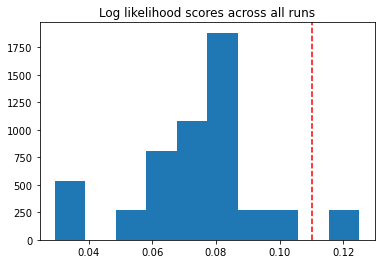

In [95]:
%matplotlib inline
# Normalize scores
# Downselect to those entries with reasonable scores
plt.figure()
plt.hist(all_scores)
print("Total num runs: ", len(all_scores))
plt.title("Log likelihood scores across all runs")
keep_thresh = 0.11
keep_shapes = all_shapes[all_scores > keep_thresh]
keep_scores = all_scores[all_scores > keep_thresh]
keep_scores = keep_scores - sp.special.logsumexp(keep_scores)
plt.axvline(keep_thresh, color="red", linestyle="--")
print("Keeping %d runs above score thresh %f" % (len(keep_scores), keep_thresh))

In [140]:
%matplotlib notebook
from scene_generation.inverse_graphics.keypoint_mcmc.particle_filter_icp import plot_kde

mins = np.array([0.0, 0.0, 0.])
maxes = np.array([1.0, 1.0, 0.5])
expected_sizes = np.array([[0.4, 0.4, 0.4],
                  [0.5, 0.2, 0.2],
                  [0.5, 0.4, 0.3],
                  [0.36, 0.3, 0.2],
                  [0.35, 0.35, 0.25]])
num_samples = np.array([10, 10, 10])
plot_kde(None, None,
         None, keep_shapes,
         keep_scores,
         mins, maxes, num_samples,
         additional_points_to_plot = expected_sizes)

NameError: name 'keep_shapes' is not defined

<IPython.core.display.Javascript object>


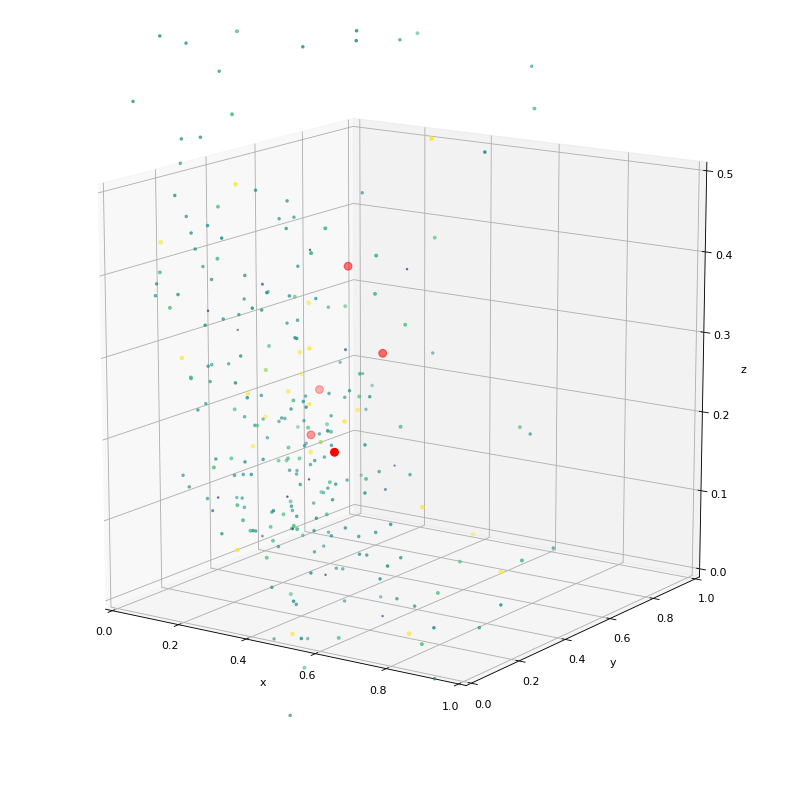

In [102]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

cm = mpl.cm.get_cmap('viridis')
c = keep_scores - np.min(keep_scores)
c /= np.max(c)
ax.scatter(keep_shapes[:, 0],
           keep_shapes[:, 1],
           keep_shapes[:, 2],
           c=cm(c), s=c*10)
           

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.set_xlim(mins[0], maxes[0])
ax.set_ylim(mins[1], maxes[1])
ax.set_zlim(mins[2], maxes[2])

ax.scatter(expected_sizes[:, 0],
           expected_sizes[:, 1],
           expected_sizes[:, 2],
           s=50,
           c="red")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Score')

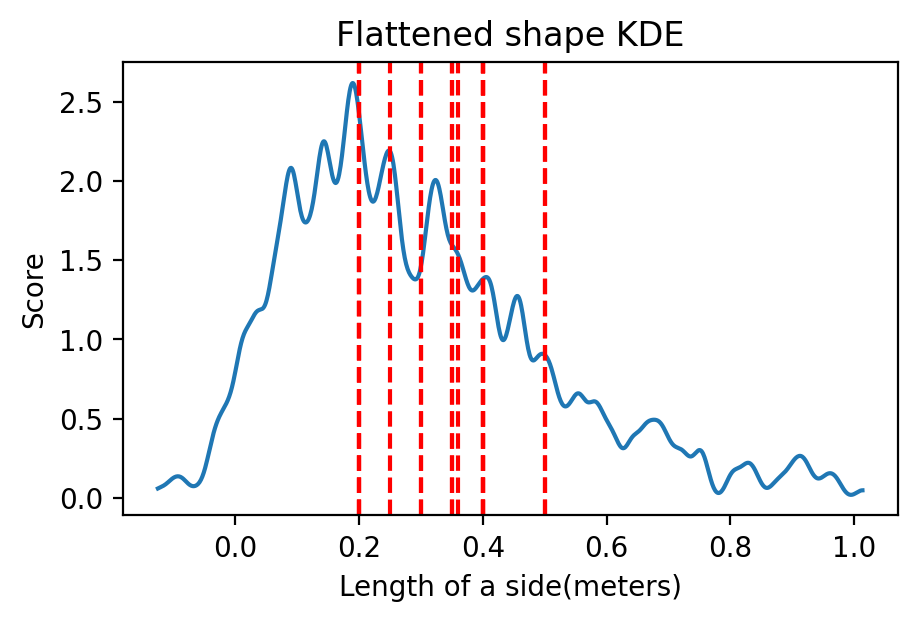

In [108]:
%matplotlib inline
# Get flattened shape and scores
import scipy as sp
flat_shapes = keep_shapes.flatten()
flat_scores = np.tile(keep_scores[:, np.newaxis], (1, 3)).flatten()
kde = gaussian_kde(flat_shapes, bw_method=0.05)
plt.figure(figsize=(5, 3), dpi=200)
xi = np.linspace(np.min(flat_shapes), np.max(flat_shapes), 1000)
z = kde(xi)
plt.plot(xi, z, label="KDE")

for v in expected_sizes.flatten():
    plt.axvline(v, c="red", linestyle="--", alpha=1.)
    

plt.title("Flattened shape KDE")
plt.xlabel("Length of a side(meters)")
plt.ylabel("Score")

Text(0, 0.5, 'Score')

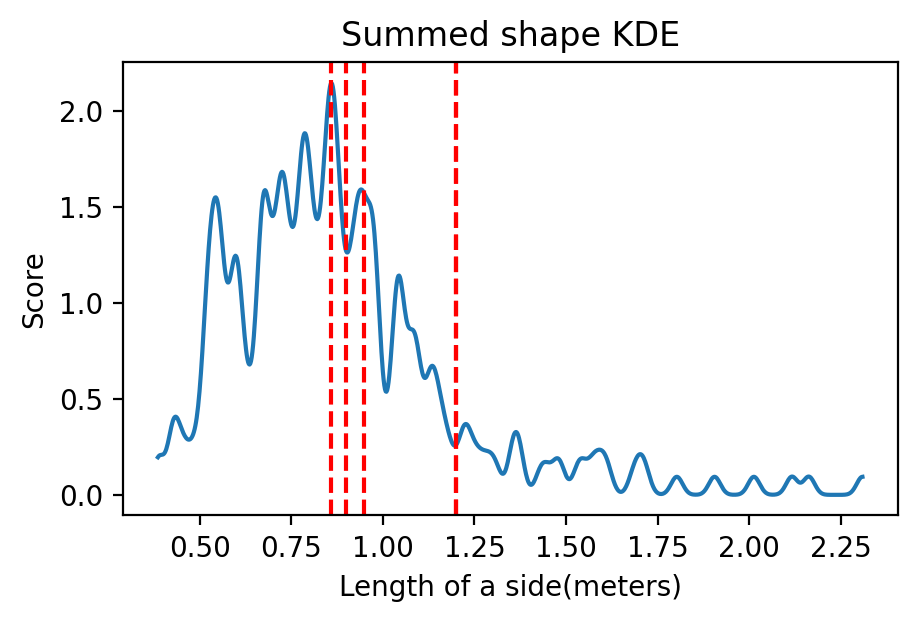

In [111]:
%matplotlib inline
# Get shape sum and scores
import scipy as sp
sum_shapes = np.sum(keep_shapes, axis=1)
kde = gaussian_kde(sum_shapes, bw_method=0.05)
plt.figure(figsize=(5, 3), dpi=200)
xi = np.linspace(np.min(sum_shapes), np.max(sum_shapes), 1000)
z = kde(xi)
plt.plot(xi, z, label="KDE")

for v in np.sum(expected_sizes, axis=1):
    plt.axvline(v, c="red", linestyle="--")
    

plt.title("Summed shape KDE")
plt.xlabel("Length of a side(meters)")
plt.ylabel("Score")

<IPython.core.display.Javascript object>


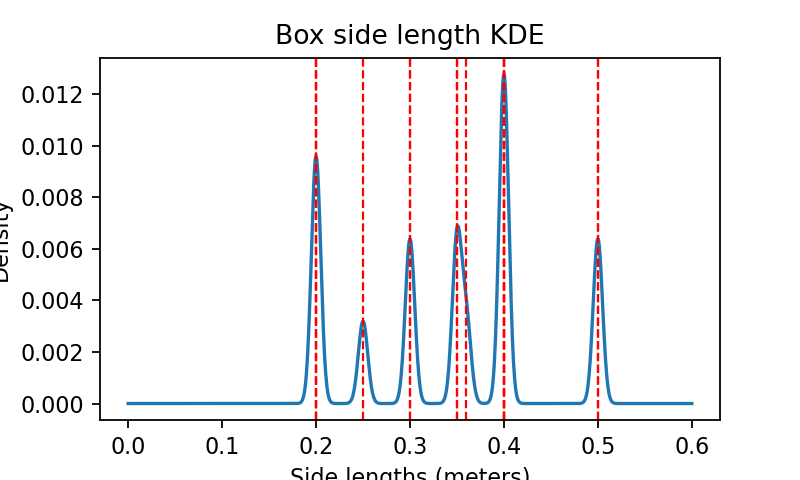

Text(0, 0.5, 'Density')

In [141]:
# for presentation figure
desired_peaks = expected_sizes.flatten() #, axis=1)
def desired_shape_dist_func(x):
    val = 0.
    for peak in desired_peaks:
        val += sp.stats.norm(loc=peak, scale=0.005).pdf(x)
    return val
plt.figure(figsize=(5, 3), dpi=200)
xi = np.linspace(0.0, 0.6, 1000)
z = desired_shape_dist_func(xi)
z /= np.sum(z)
plt.plot(xi, z)

for v in expected_sizes.flatten():
    plt.axvline(v, c="red", linestyle="--", linewidth=1)
    
plt.title("Box side length KDE")
plt.xlabel("Side lengths (meters)")
plt.ylabel("Density")